In [1]:
import cv2
print(cv2.__version__)

4.10.0


In [2]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = f"../checkpoints/sam2_hiera_base_plus.pt"
model_cfg = "sam2_hiera_b+.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint)

In [3]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))
    
def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

In [4]:
video_path = f"videos/video中.mp4"
output_path = f"images/ai_coach"

In [6]:
!ffmpeg -i {video_path} -q:v 2 -start_number 0 {output_path}/'%05d.jpg'

ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libsw

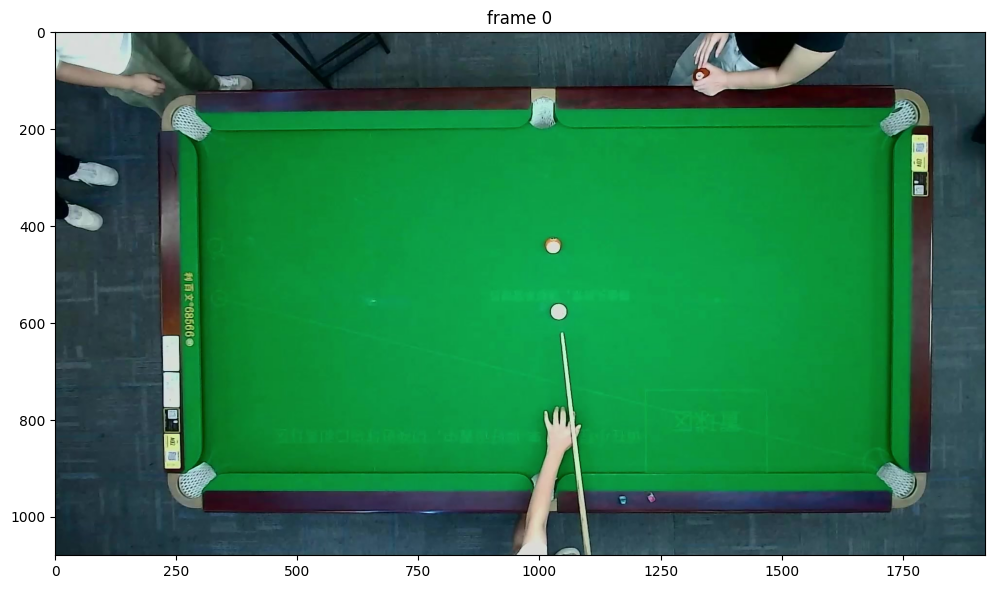

In [5]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = f"images/ai_coach"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(12, 8))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [60]:
# reset stage only if required
predictor.reset_state(inference_state)

In [6]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 226/226 [00:11<00:00, 20.10it/s]


In [7]:
import os
import ultralytics
# clearing the output
from IPython import display
display.clear_output()
# running checks
ultralytics.checks()
# importing YOLO
from ultralytics import YOLO
from IPython.display import display, Image

Ultralytics YOLOv8.2.82 🚀 Python-3.10.8 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)
Setup complete ✅ (128 CPUs, 1007.5 GB RAM, 12.8/30.0 GB disk)


In [5]:
from ultralytics import YOLO

# Load a pretrained ai_coach YOLOv8n model
model = YOLO("weights/train_coach10_640.pt")

In [6]:
!yolo task=detect mode=predict model='weights/train_coach10_640.pt' source="images/ai_coach/00060.jpg" save=True save_txt=True save_conf=True

Ultralytics YOLOv8.2.82 🚀 Python-3.10.8 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs

image 1/1 /root/segment-anything-2/notebooks/images/ai_coach/00060.jpg: 384x640 1 ball, 2 cue sticks, 5 pockets, 1 table, 1 white ball, 89.6ms
Speed: 4.6ms preprocess, 89.6ms inference, 96.8ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict8
1 label saved to runs/detect/predict8/labels
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [8]:
# 获得目标球的坐标
def convert_normalized_to_original_bbox(normalized_bbox, image_width, image_height):  
    # 解析归一化坐标  
    cx, cy, w, h = normalized_bbox  
    
    # 计算原始图像坐标  
    original_cx = cx * image_width  
    original_cy = cy * image_height  
    original_w = w * image_width  
    original_h = h * image_height  
    
    # 计算左上角和右下角坐标  
    x1 = int(original_cx - original_w / 2)
    y1 = int(original_cy - original_h / 2)  
    x2 = int(original_cx + original_w / 2)
    y2 = int(original_cy + original_h / 2)
    
    return (x1, y1, x2, y2)  

# 归一化的检测框 (cx, cy, w, h)  
normalized_bbox = (0.541372,0.534685,0.0191637,0.0317513)  
# 原始图像尺寸  
image_width = 1920  
image_height = 1080  

# 转换为原始坐标  
original_bbox = convert_normalized_to_original_bbox(normalized_bbox, image_width, image_height)  
print(f"Original bbox coordinates: {original_bbox}")
# 1006.5      456.44      1042.7      492.95

Original bbox coordinates: (1021, 560, 1057, 594)


In [7]:
# use the bounding box coordinates of the gymnast in the predictor
import numpy as np
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 4  # give a unique id to each object we interact with (it can be any integers)

# Let's add a box at (x_min, y_min, x_max, y_max) to get started
box = np.array([1009, 424, 1046, 459], dtype=np.float32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    box=box,
)

NameError: name 'inference_state' is not defined

In [8]:
# run propagation throughout the video and collect the results in a dict
from PIL import Image
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 15
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

NameError: name 'inference_state' is not defined

In [82]:
!yolo task=detect mode=predict model='weights/train_coach10_640.pt' source="images/ai_coach/00165.jpg" save=True save_txt=True save_conf=True

Ultralytics YOLOv8.2.82 🚀 Python-3.10.8 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs

image 1/1 /root/segment-anything-2/notebooks/images/ai_coach/00165.jpg: 384x640 1 cue stick, 5 pockets, 1 table, 1 white ball, 102.7ms
Speed: 6.2ms preprocess, 102.7ms inference, 484.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict4
1 label saved to runs/detect/predict4/labels
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [15]:
# 转换为原始坐标  
normalized_bbox150 = (0.519416,0.528355, 0.0190885, 0.0329919)
original_bbox150 = convert_normalized_to_original_bbox(normalized_bbox150, image_width, image_height)  
print(f"Original bbox coordinates: {original_bbox150}")  

Original bbox coordinates: (978, 552, 1015, 588)


In [16]:
# 转换为原始坐标  
normalized_bbox165 = (0.516401, 0.548948, 0.0186651, 0.032582)
original_bbox165 = convert_normalized_to_original_bbox(normalized_bbox165, image_width, image_height)  
print(f"Original bbox coordinates: {original_bbox165}")  

Original bbox coordinates: (973, 575, 1009, 610)


In [17]:
import torch  

def get_box_center_point(box):  
    # 提取边界框的坐标  
    x1, y1, x2, y2 = box  
    # 计算中心点  
    center_x = round((x1 + x2) / 2.0)
    center_y = round((y1 + y2) / 2.0)
    # 返回中心点作为一个二维向量  
    return torch.tensor([[center_x, center_y]], dtype=torch.float32)
box150 = original_bbox150
center_point150 = get_box_center_point(box150)
print("center_point150: ", center_point150)

box165 = original_bbox165
center_point165 = get_box_center_point(box165)
print("center_point165:", center_point165)

center_point150:  tensor([[996., 570.]])
center_point165: tensor([[991., 592.]])


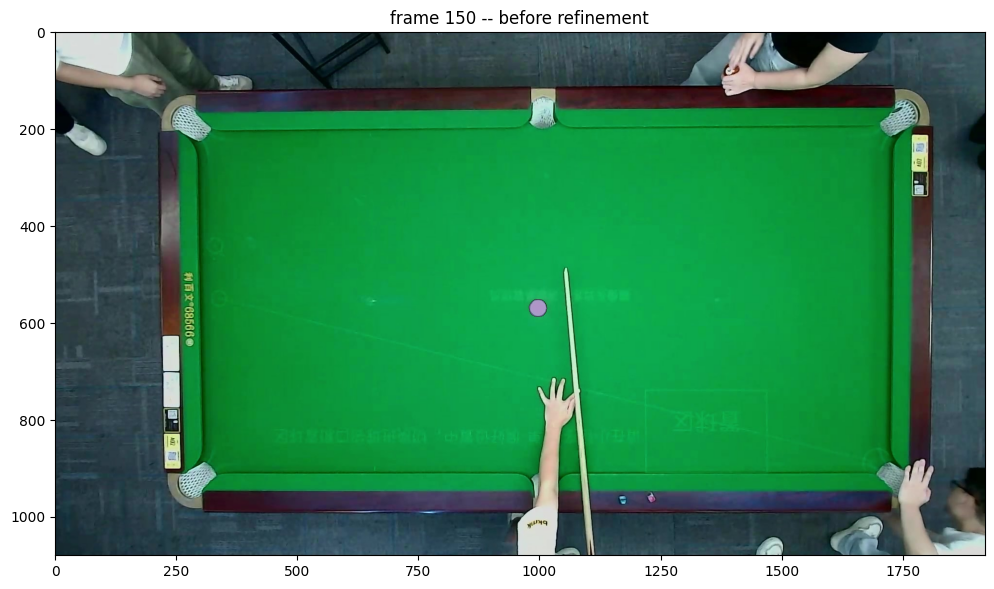

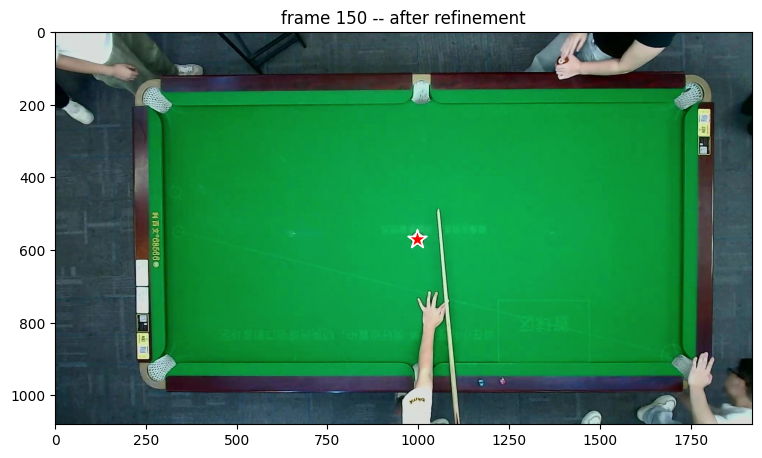

In [18]:
ann_frame_idx = 150  # further refine some details on this frame
ann_obj_id = 4  # give a unique id to the object we interact with (it can be any integers)

# show the segment before further refinement
plt.figure(figsize=(12, 8))
plt.title(f"frame {ann_frame_idx} -- before refinement")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_mask(video_segments[ann_frame_idx][ann_obj_id], plt.gca(), obj_id=ann_obj_id)

# Let's add a negative box on this frame to refine the segment
# for labels, `1` means positive click and `0` means negative click
labels = np.array([0], np.int32)
box = np.array([991, 506, 1028, 542], dtype=np.float32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    labels=labels,
    # box=box,
    points=center_point150,
)

# show the segment after the further refinement
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx} -- after refinement")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
# show_box(box, plt.gca())
show_points(center_point150, labels, plt.gca())
show_mask((out_mask_logits > 0.0).cpu().numpy(), plt.gca(), obj_id=ann_obj_id)

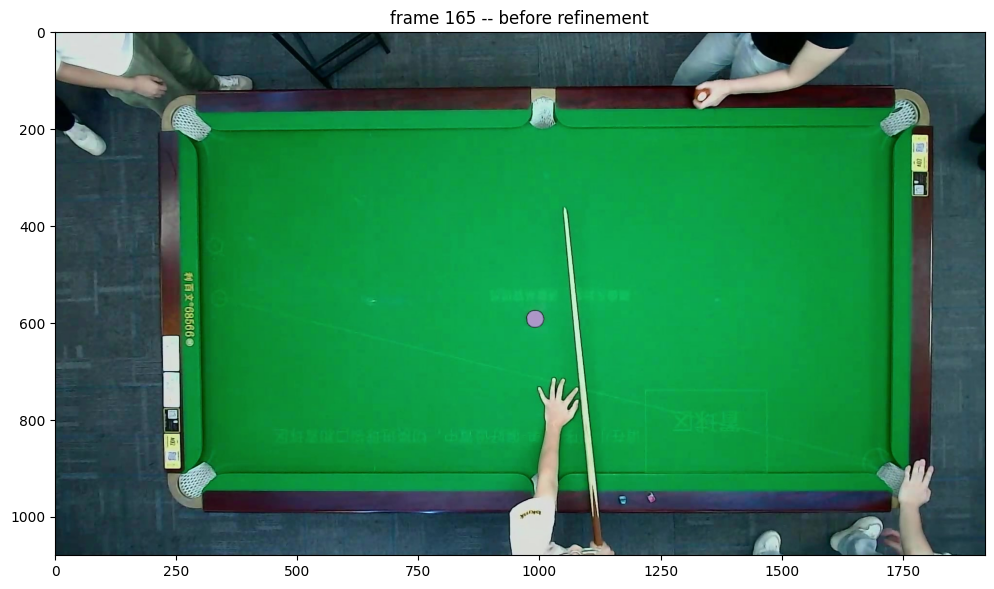

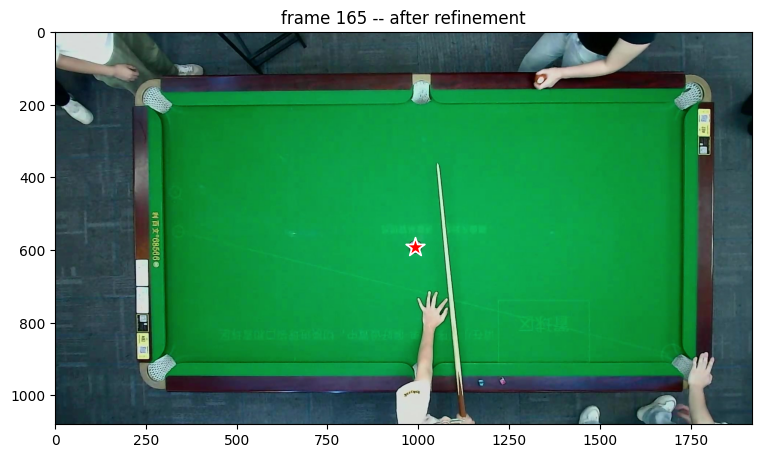

In [19]:
ann_frame_idx = 165  # further refine some details on this frame
ann_obj_id = 4  # give a unique id to the object we interact with (it can be any integers)

# show the segment before further refinement
plt.figure(figsize=(12, 8))
plt.title(f"frame {ann_frame_idx} -- before refinement")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_mask(video_segments[ann_frame_idx][ann_obj_id], plt.gca(), obj_id=ann_obj_id)

# Let's add a negative box on this frame to refine the segment
# for labels, `1` means positive click and `0` means negative click
labels = np.array([0], np.int32)
box = np.array([991, 506, 1028, 542], dtype=np.float32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    labels=labels,
    # box=box,
    points=center_point165,
)


# show the segment after the further refinement
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx} -- after refinement")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
# show_box(box, plt.gca())
show_points(center_point165, labels, plt.gca())
show_mask((out_mask_logits > 0.0).cpu().numpy(), plt.gca(), obj_id=ann_obj_id)

propagate in video: 100%|██████████| 226/226 [00:17<00:00, 12.86it/s]


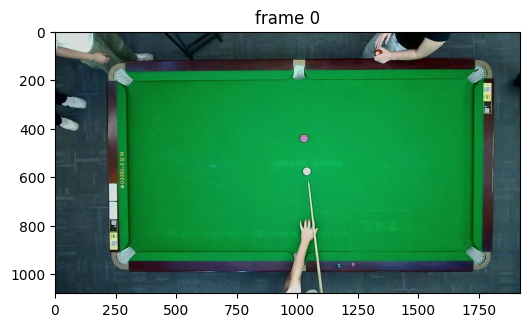

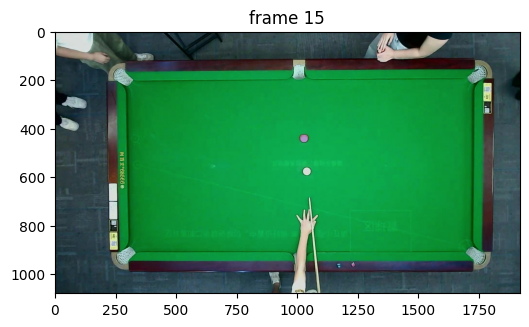

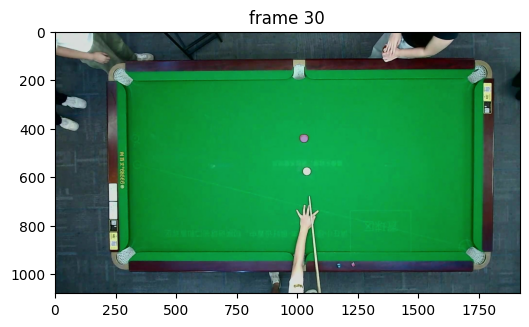

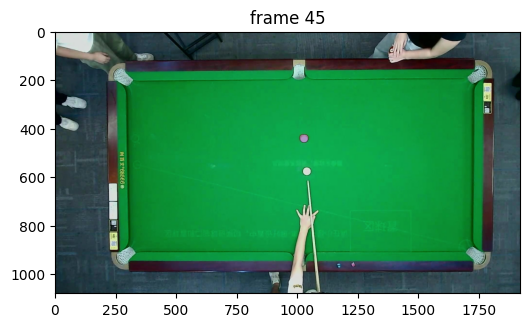

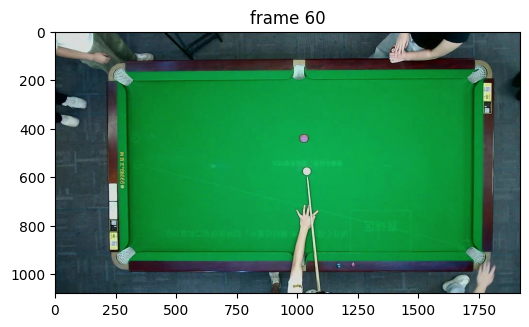

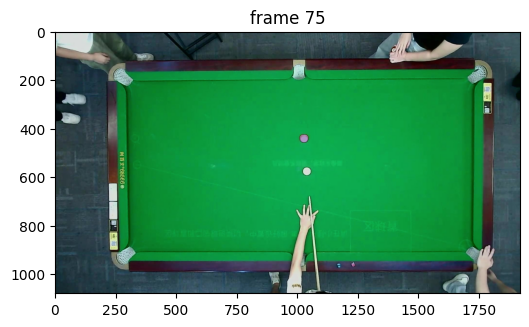

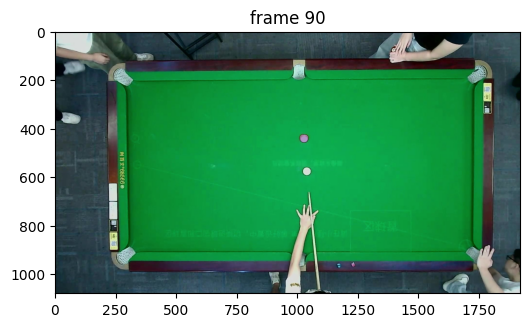

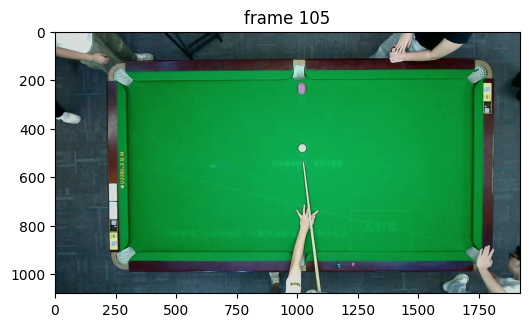

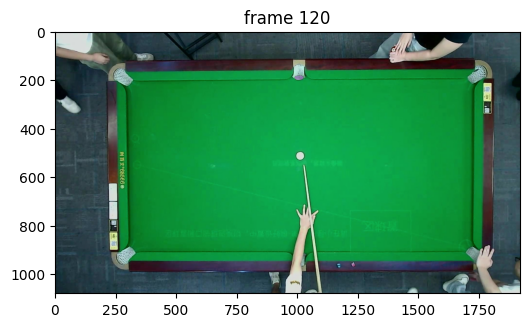

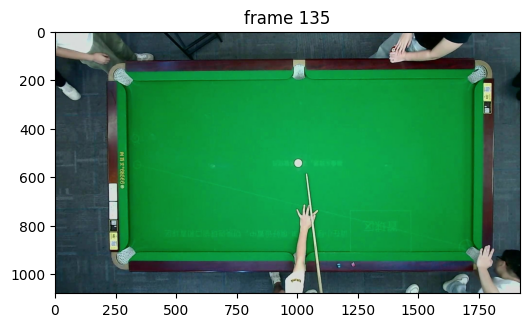

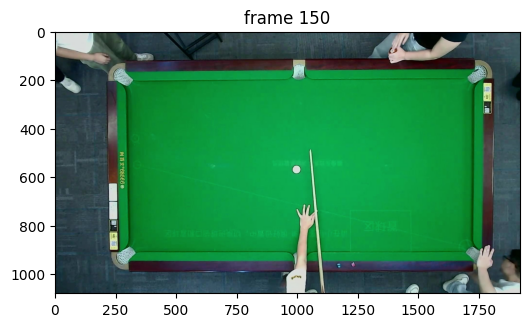

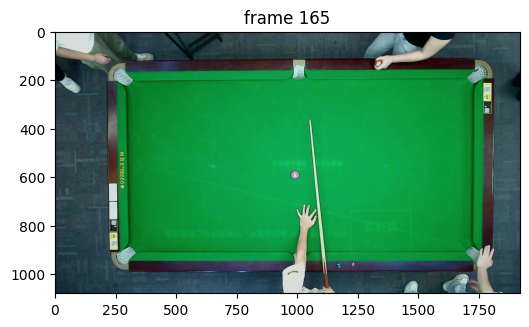

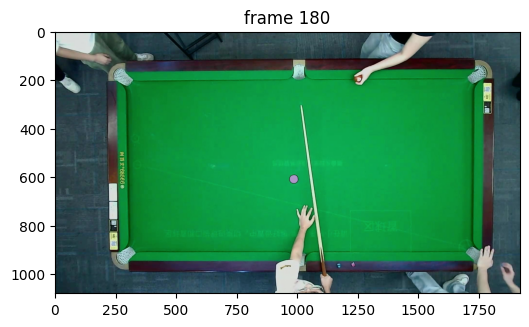

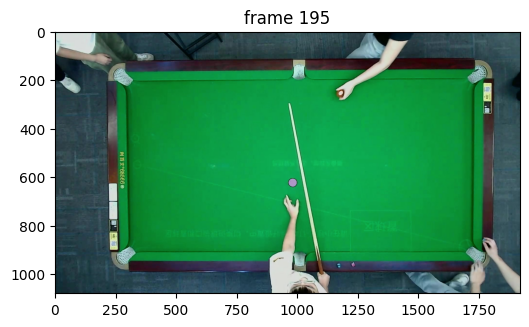

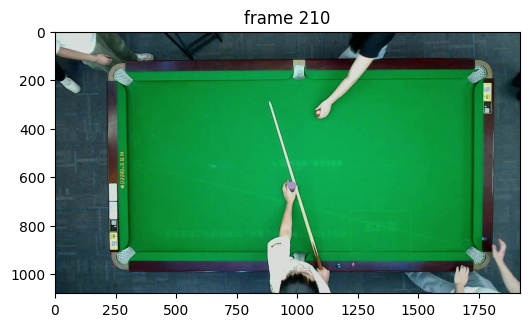

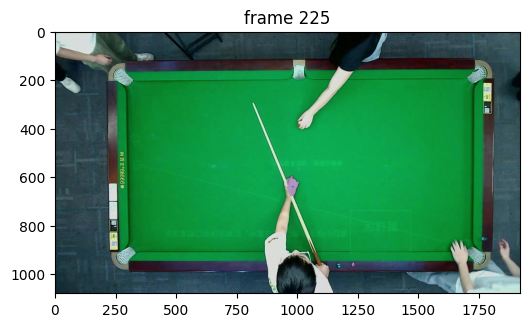

In [20]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 15
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)